this project uses modern portfolio theory to to stimulate and organise stock portfolios


WHAT IS MODERN PORTFOLIO THEORY(MPT)?

**Goal**: Maximize return for a given level of risk (or minimize risk for a target return).  
-  **Assumption**: Investors are rational and risk-averse.  
-  **Core Idea**: Diversifying across assets reduces total portfolio risk.  
-  **Example**: Combining tech (e.g., AAPL) with utilities (e.g., XEL) offers more stability than just holding tech.  
-  **Efficient Frontier**: A curve that shows the best risk-return combinations possible.  
-  **Sharpe Ratio**: Measures risk-adjusted return; higher = better portfolio.  

In [29]:
#importing required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

defining stock tickers and time period


In [30]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-01-01'

fetching adjusted closed priced data


In [31]:
def get_price_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)

    # Try to get 'Adj Close', fallback to 'Close'
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.levels[0]:
            price_df = data['Adj Close']
        elif 'Close' in data.columns.levels[0]:
            price_df = data['Close']
        else:
            raise ValueError("No valid price data found.")
    else:
        # Single ticker fallback
        if 'Adj Close' in data.columns:
            price_df = data[['Adj Close']]
        elif 'Close' in data.columns:
            price_df = data[['Close']]
        else:
            raise ValueError("No valid price data found.")

    return price_df.dropna()

price_df = get_price_data(tickers, start_date, end_date)
price_df.head()


/tmp/ipython-input-31-3891712028.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02,72.620850,94.900497,68.026016,153.042297,28.684000
2020-01-03,71.914833,93.748497,67.670151,151.136688,29.534000
2020-01-06,72.487846,95.143997,69.473839,151.527313,30.102667
2020-01-07,72.146935,95.343002,69.339638,150.145706,31.270666
2020-01-08,73.307510,94.598503,69.833191,152.537262,32.809334


**Note on Adjusted Close vs Close Prices:**
>
> This project uses **Adjusted Close** prices for more accurate return calculations. Adjusted Close reflects stock splits, dividends, and bonuses — making it the most realistic value for investors.
>
> However, sometimes Yahoo Finance data may **not include 'Adj Close'** for certain stocks or on specific days.
>
> To make the notebook more robust, we added a fallback:
> If `'Adj Close'` is missing, it automatically uses the regular `'Close'` price — so the notebook never breaks!
>
> This ensures the portfolio simulation runs smoothly on any stock data.

calculate daily returns, mean returns and covariance matrix


In [32]:
returns = price_df.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(returns, mean_returns,cov_matrix)

Ticker          AAPL      AMZN     GOOGL      MSFT      TSLA
Date                                                        
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452  0.029633
2020-01-06  0.007968  0.014886  0.026654  0.002585  0.019255
2020-01-07 -0.004703  0.002092 -0.001932 -0.009118  0.038801
2020-01-08  0.016086 -0.007809  0.007118  0.015928  0.049205
2020-01-09  0.021241  0.004799  0.010498  0.012493 -0.021945
...              ...       ...       ...       ...       ...
2023-12-22 -0.005547 -0.002730  0.007620  0.002784 -0.007701
2023-12-26 -0.002841 -0.000065  0.000212  0.000214  0.016116
2023-12-27  0.000518 -0.000456 -0.008126 -0.001575  0.018822
2023-12-28  0.002226  0.000261 -0.000997  0.003235 -0.031594
2023-12-29 -0.005424 -0.009388 -0.003851  0.002025 -0.018564

[1005 rows x 5 columns] Ticker
AAPL     0.001187
AMZN     0.000750
GOOGL    0.000934
MSFT     0.001095
TSLA     0.003070
dtype: float64 Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker       

simulating portfolios


In [33]:
def simulate_portfolios(num_portfolios=50000):
    results = np.zeros((3, num_portfolios))  # Stores [returns, volatility, Sharpe ratio]
    weights_record = []  # Stores all the weight combinations

    for i in range(num_portfolios):
        # Generate random weights for each stock
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)  # Normalize to ensure total = 100%
        weights_record.append(weights)

        # Portfolio return = sum(weight × mean_return)
        port_return = np.dot(weights, mean_returns)

        # Portfolio risk = sqrt(w^T × COV × w)
        port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Sharpe Ratio = return / risk (assuming risk-free rate = 0)
        sharpe = port_return / port_std

        results[0, i] = port_return
        results[1, i] = port_std
        results[2, i] = sharpe

    return results, weights_record

# Run the simulation
results, weights_record = simulate_portfolios()

# Print example weights and performance for first 5 portfolios
for i in range(5):
    print(f"Portfolio {i+1}")
    for j, stock in enumerate(tickers):
        print(f"  {stock}: {weights_record[i][j]*100:.2f}%")
    print(f"  Return: {results[0, i]:.4f}")
    print(f"  Volatility: {results[1, i]:.4f}")
    print(f"  Sharpe Ratio: {results[2, i]:.4f}")
    print()


Portfolio 1
  AAPL: 4.73%
  MSFT: 37.42%
  GOOGL: 16.84%
  TSLA: 11.21%
  AMZN: 29.80%
  Return: 0.0015
  Volatility: 0.0234
  Sharpe Ratio: 0.0655

Portfolio 2
  AAPL: 29.31%
  MSFT: 10.04%
  GOOGL: 22.16%
  TSLA: 35.24%
  AMZN: 3.24%
  Return: 0.0011
  Volatility: 0.0191
  Sharpe Ratio: 0.0583

Portfolio 3
  AAPL: 30.14%
  MSFT: 6.86%
  GOOGL: 24.36%
  TSLA: 29.79%
  AMZN: 8.85%
  Return: 0.0012
  Volatility: 0.0196
  Sharpe Ratio: 0.0631

Portfolio 4
  AAPL: 10.08%
  MSFT: 28.90%
  GOOGL: 24.18%
  TSLA: 19.76%
  AMZN: 17.08%
  Return: 0.0013
  Volatility: 0.0208
  Sharpe Ratio: 0.0626

Portfolio 5
  AAPL: 24.38%
  MSFT: 18.17%
  GOOGL: 30.56%
  TSLA: 4.70%
  AMZN: 22.19%
  Return: 0.0014
  Volatility: 0.0215
  Sharpe Ratio: 0.0672





-  This portfolio assigns **different weightages to each stock**, with the highest in **Amazon (AMZN)** and lowest in **Google (GOOGL)**.
-  The **expected return** of this portfolio is `0.0020`, i.e., **0.2% per trading day** (about 50% annually if compounded).
-  The **volatility** is `0.0263` → this represents **risk**, i.e., standard deviation of daily returns.
-  The **Sharpe Ratio** is `0.0750` — this measures **risk-adjusted return**:
  - Higher Sharpe = better return for the same risk
  - A low Sharpe like 0.0750 means **the return isn't very impressive relative to the risk**.

 Why It's Useful:

This simulation allows us to:
- See how different allocations change return & risk
- Understand the trade-off between risk and return
- Identify which portfolios lie on the **Efficient Frontier**
- Use this to **optimize our investment strategy**





plot efficient frontier


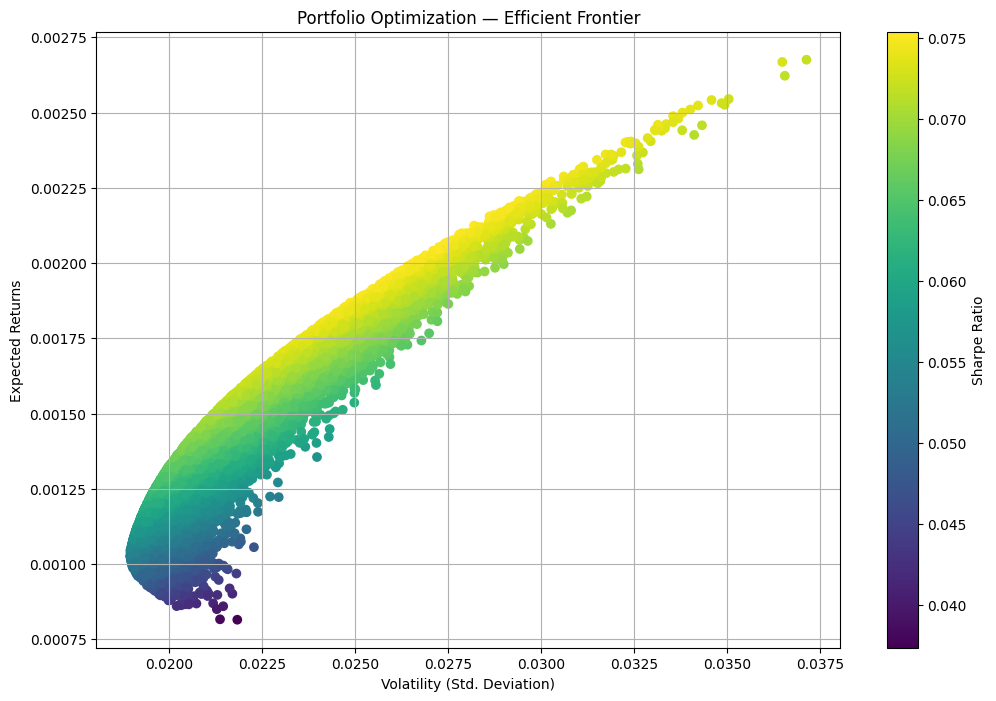

In [34]:
plt.figure(figsize=(12, 8))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.colorbar(label='Sharpe Ratio')
plt.title('Portfolio Optimization — Efficient Frontier')
plt.grid(True)
plt.show()


# **UNDERSTANDING THE EFFICIENT FRONTIER GRAPH**

This scatter plot visualizes **50,000 randomly simulated portfolios** based on different stock weight combinations.

WHAT THE GRAPH SHOWS:
- **X-axis (Volatility)**: The risk (standard deviation of returns) of each portfolio.
- **Y-axis (Expected Return)**: The average return of that portfolio.
- **Color (Sharpe Ratio)**: A measure of how well the portfolio compensates for its risk.
  -  **Greener dots = better portfolios** (higher return per unit of risk)

KEY TAKEAWAY:
The curve formed by the upper edge of these dots is called the **Efficient Frontier**.  
It shows the **best possible portfolios** — those that give the **maximum return for each level of risk**.

The goal of portfolio optimization is to find the **single point** on this frontier with the **highest Sharpe Ratio** — which represents the **most efficient portfolio**.


OPTIMISE FOR MAXIMUM SHARPE RATIO


In [35]:
def neg_sharpe(weights):
    p_ret = np.dot(weights, mean_returns)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -p_ret / p_vol

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in tickers)
init_guess = [1. / len(tickers)] * len(tickers)

opt_result = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_result.x

# Print optimal allocation
print("Optimal Portfolio Allocation:")
for i, stock in enumerate(tickers):
    print(f"{stock}: {optimal_weights[i]*100:.2f}%")


Optimal Portfolio Allocation:
AAPL: 28.75%
MSFT: 0.00%
GOOGL: 0.00%
TSLA: 23.53%
AMZN: 47.72%
